In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import scipy.optimize as sco
import scipy.constants as c
from scipy.optimize import curve_fit as cf
import pandas as pd

In [2]:
def gauss(x,mu,sig,A,b):
    return A*np.exp( - (x-mu)**2 / 2 / sig**2) +b

In [3]:
def plotGraph(ordner, anzahl, xoff=0, yoff=0, g=False, visible=True, save_name=None, shift_graph_num=-1,alpha=1):
    if visible:
        fig,ax=plt.subplots(dpi=144)
        ax.plot([],[]," ", label=ordner)
    if g: rangee= np.array([5,3,4])[:anzahl]
    else: rangee = range(anzahl)
        
    data_array=[]
    for n in rangee:
        xShift,yShift=0,0
        data=pd.read_csv("Data/{}/ALL000{}/F000{}CH1.csv".format(ordner,n,n),skiprows=17)
        
        if n==rangee[shift_graph_num ]: xShift,yShift = xoff,yoff
        t=np.array(data.values[:,3]).astype(float) 
        intens=np.array(data.values[:,4]).astype(float) + yShift

        t=t-min(t) # Damit die Skala bei 0 realtiv anfängt -- keine neg Energien
        time= t*1000 + xShift
        data_array.append(time)
        data_array.append(intens)
        
        if visible==False: continue
        ax.plot(time,intens, label="{}".format(n),alpha=alpha)
        ax.set(yticks=[],ylabel="$Intenstiy\; [a.u.]$", xlabel="$Time\; [ns]$"
               , xticks=np.linspace(0,10*round(max(time)/10),1+int(10*round(max(time)/10)/5)))
    
    if visible:
        ax.legend()
        ax.grid(which="Both")
        if save_name != None: fig.savefig("Plots/{}.png".format(save_name))
        
    
    return data_array # time,intens , time,intens , ... -> [i],[i+1] to call
    
#plotGraph("87F2", 3, g=True) # andere 3, die später aufgenommen wurden...
#plotGraph("87F2", 3, xoff=.65, yoff=-1)

In [4]:
# Fit for the sidebands to get an energy 

def find_cloeset_Pos_to_Value(array,value):
    temp=0
    count=0
    for i in range(len(array)):
        if temp < value:
            temp=array[i]
            count+=1
            continue
        return int(count)  

def gaussFit(time, intens, mu_guess,width_list, plot_list,ordner ,save_name=None):
    mu_list,dmu_list=[],[]
    time_range=np.linspace(min(time),max(time),len(time))
    
    fig,ax=plt.subplots(dpi=144)
    ax.plot(time,intens,alpha=.4)
    ax.plot([],[]," ", label=ordner)
    
    for i in range(len(mu_guess)):   
        print("found one")
        peak_pos=find_cloeset_Pos_to_Value(time,mu_guess[i])
        
        width=width_list[i]
        plot_array=plot_list[i]
        fit_width= time_range[peak_pos-width[0] : peak_pos+width[1]]
        plot_width=time_range[peak_pos-width[0]-plot_array[0] : peak_pos+width[1]+plot_array[1]]
        
        popt,pcov = cf(gauss, fit_width, intens[peak_pos-width[0] : peak_pos+width[1]], p0=[mu_guess[i], 1, 1, 1])
        ax.plot( plot_width, gauss(plot_width,*popt),label=i+1)
        mu_list.append(popt[0])
        dmu_list.append(abs(popt[1])) # sigma als fehler auf mu
    
    ax.set(yticks=[],ylabel="$Intenstiy\; [a.u.]$", xlabel="$Time\; [ns]$")
    ax.legend()
    if save_name != None: fig.savefig("Plots/{}.png".format(save_name))
    
    return mu_list,dmu_list

# Erste Kalibration, zwar besser, jedoch lein Zusammenhang mit anderen Daten
    
data= plotGraph("87F2", 3, xoff=.5, yoff=-1,visible=True,save_name="Calibration_Second_All")
dataSet=4
mu_guess= [10,13,17.5,20.8,22.9, 27.5,32.3,36,39.5]
width_list=[[50,50] for i in mu_guess]
plot_list=[[20,20] for i in mu_guess]

gaussFit(data[dataSet], data[dataSet+1]-data[0+1], mu_guess ,width_list,plot_list,"87F2",save_name="Calibration_First")

[  3.     3.01   3.02 ...,  27.79  27.8   27.81] [  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   2.47900000e+01
   2.48000000e+01   2.48100000e+01]
found one
found one
found one
found one
found one
found one
found one
found one
found one


([5.6543169164829497,
  7.7934519912384115,
  10.178855346614693,
  12.21140927926554,
  13.597426307742179,
  15.578435420873825,
  18.948600803872814,
  21.231351988909079,
  23.342679141689107],
 [0.18874043987029751,
  0.2199189294908041,
  0.29536719295289998,
  0.20120856142239957,
  0.2041070058601068,
  0.24865532766960088,
  0.19646746683394706,
  0.22234999128631425,
  0.22717791537051654])

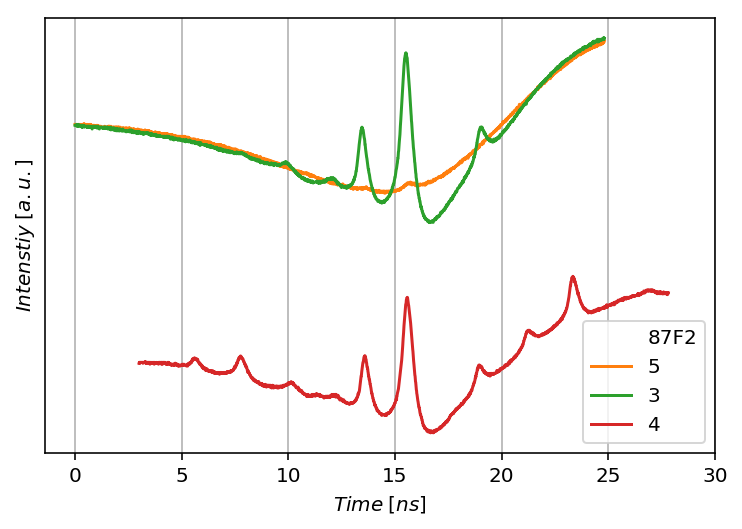

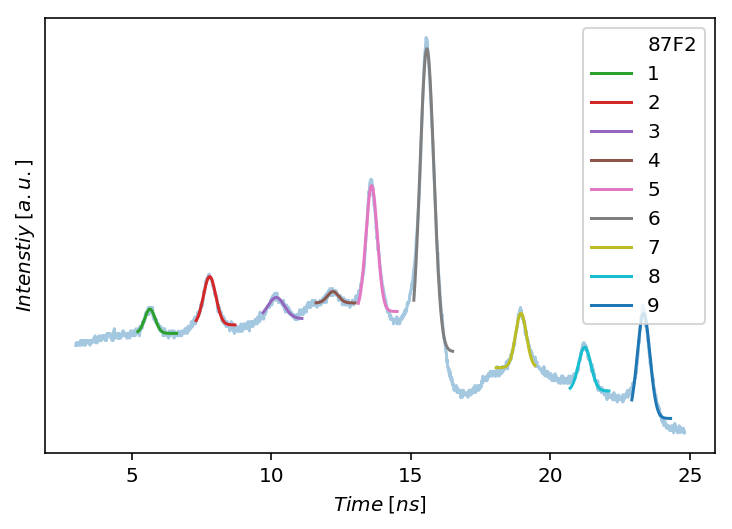

In [5]:
data= plotGraph("87F2", 3, g=True,visible=True, xoff=3,yoff=-1,save_name="Calibration_Second_All")
dataSet=4
mu_guess= np.array([5.9,8,10.4,12.3,13.8, 15.8,18.75,21.4,23.6])
width_list=[[50,50] for i in mu_guess]
plot_list=[[20,20] for i in mu_guess]

data[dataSet+1]-data[0+1]

def shuffle_right(data,diff_offset=0): # SOLL: Erstellt eine ordentliche Differenzkurve erstellen, bzgl xoff
    print(data[0],data[2])
    shuffle,j ,first,stop=[],0 ,True,0
    for i in range(len(data[2])):
        a=round(data[0][j]*100)
        b=round(data[2][i]*100)

        if a != b: continue
        if first: 
            stop=i
            first=False
        shuffle.append( data[1][j]-data[3][i])
        j+=1
    return shuffle ,stop

shuffle, stop=shuffle_right([data[dataSet],data[dataSet+1],data[0],data[1]] , diff_offset=-1)
        
gaussFit(data[dataSet][stop:]-3, shuffle, mu_guess ,width_list,plot_list,"87F2",save_name="Calibration_Second_Real")

3.36
found one
found one
found one
found one


([1.8312511314527489,
  3.3988822553361158,
  4.193398232643319,
  5.8168216112723714],
 [0.26556908907020504,
  0.20842392585902006,
  0.20182201135756841,
  0.15271147869634069])

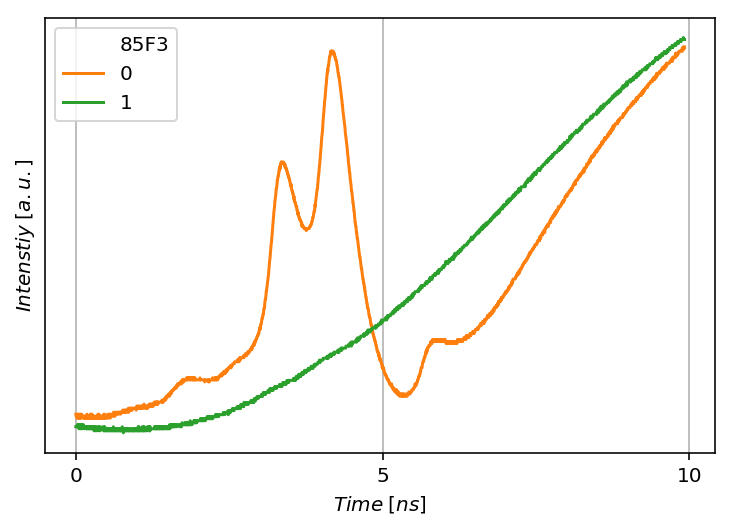

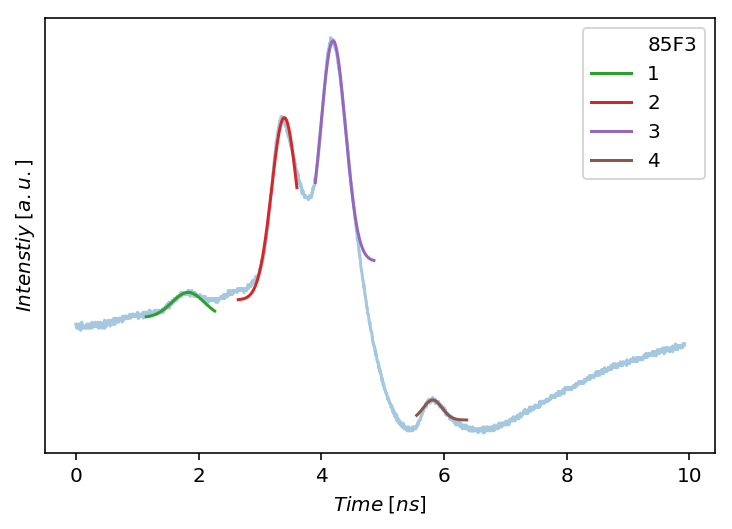

In [6]:
name="85F3"
data= plotGraph(name, 2,yoff=-.05,visible=True,save_name="{}_Both".format(name))
dataSet=0
print(data[dataSet][840])
mu_guess= [1.7,3.2,4.3,5.95]
width_list=[[70,70],[70,100],[100,70],[70,35]]
plot_list = [[70,70],[70,0],[0,70],[30,70]]

gaussFit(data[dataSet], data[dataSet+1]-data[2+1], mu_guess ,width_list,plot_list,name,save_name="{}_Diff".format(name))

found one
found one
found one
found one


([3.4947630486564281,
  4.8310666829329518,
  5.3661015986227278,
  6.136599482440265],
 [21.790909241617591,
  1.2062437666977346,
  0.76508938106947422,
  11.675454422452061])

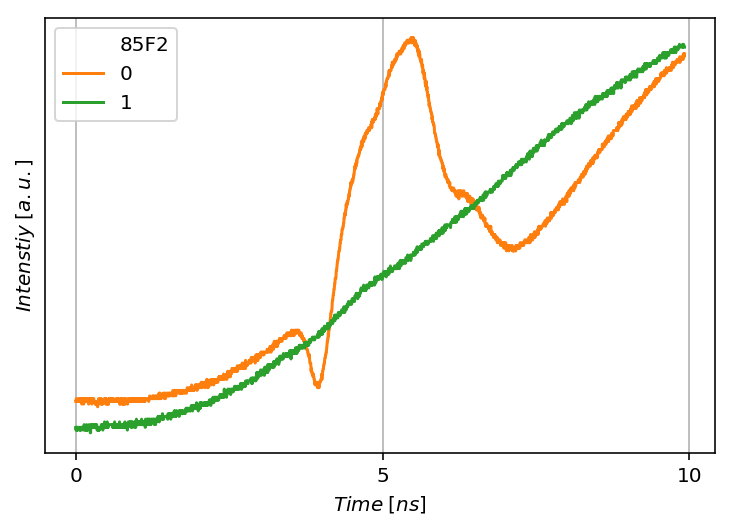

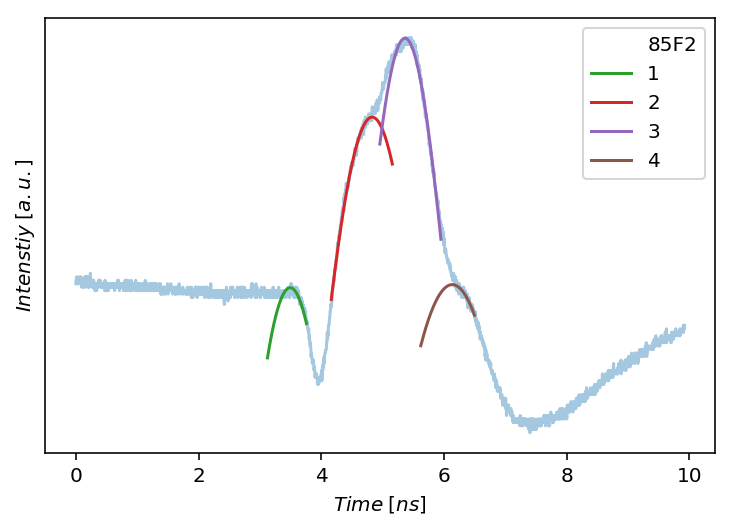

In [7]:
name="85F2"
data= plotGraph(name, 2,yoff=-.05,visible=True,save_name="{}_Both".format(name))
dataSet=0
mu_guess= [3.6,4.8,5.35,6.3]
width_list=[[70,70],[200,10],[50,140],[30,60]]
plot_list= [[50,-30],[-40,80],[50,10],[140,-10]]
gaussFit(data[dataSet], data[dataSet+1]-data[2+1], mu_guess ,width_list,plot_list,name,save_name="{}_Diff".format(name))

found one
found one
found one
found one
found one


([1.5826689622162429,
  1.786803893109016,
  3.9871947335236548,
  4.8415521557701249,
  6.9821311803939334],
 [0.53005248070185673,
  0.22352867494142661,
  0.7015775285506457,
  0.19551933655340215,
  0.29160231178236123])

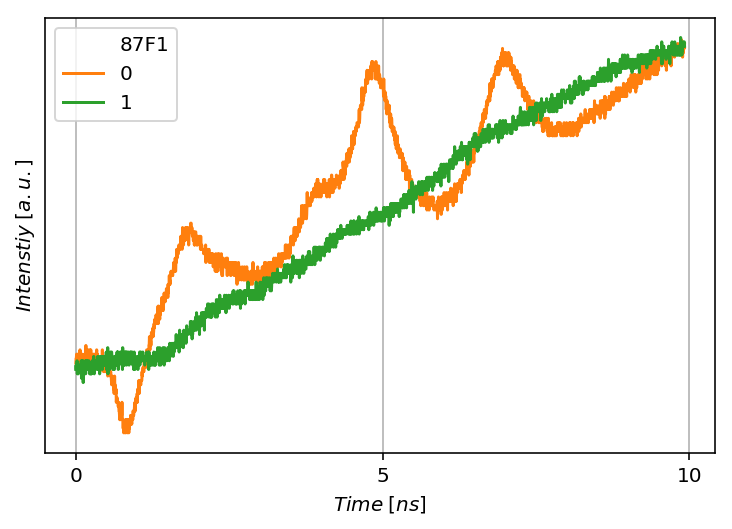

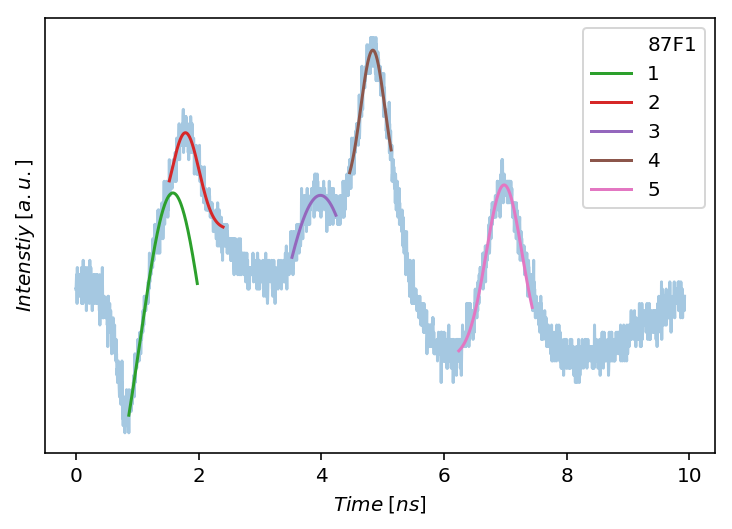

In [8]:
name="87F1"
data= plotGraph(name, 2,yoff=-.013,visible=True,save_name="{}_Both".format(name))
dataSet=0
mu_guess= [1.5,2,4, 4.7,6.8]
width_list=[[140,0],[70,70],[120,60],[60,80],[90,90]]
plot_list= [[20,120],[50,30],[0,0],[0,30],[50,70]]
gaussFit(data[dataSet], data[dataSet+1]-data[2+1], mu_guess ,width_list,plot_list,name,save_name="{}_Diff".format(name))

found one
found one
found one
found one
found one
found one


([7.7703165202964595,
  9.9038372988181074,
  12.088451924346394,
  13.46268295828088,
  15.511812693708434,
  19.045273346590033],
 [0.29594488945352238,
  0.25810646468610088,
  0.31757111230105411,
  0.18623689379630687,
  0.27254831971058657,
  0.188469623609473])

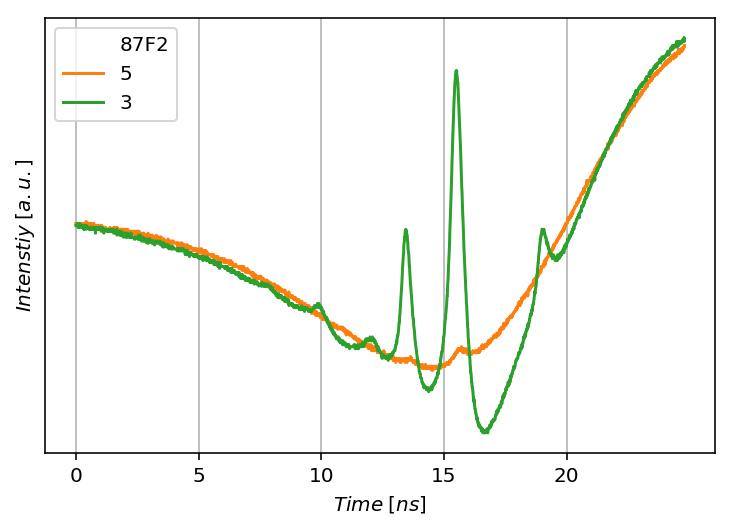

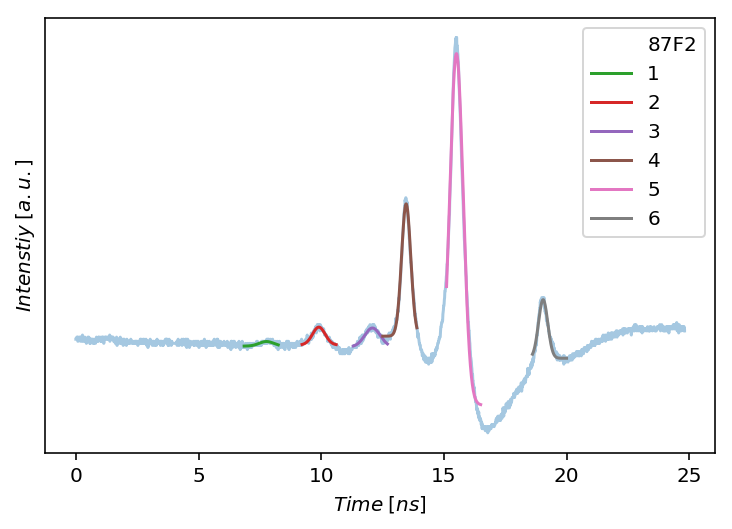

In [9]:
name="87F2"
data= plotGraph(name, 2,g=True,visible=True,save_name="{}_Both".format(name))
dataSet=2
mu_guess= [7.55,9.9,12,13.2,15.8,19.3]
width_list=[[70,70],[70,70],[70,70],[70,70],[70,70],[70,70]]
plot_list= [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
gaussFit(data[dataSet], data[dataSet+1]-data[0+1], mu_guess ,width_list,plot_list,name,save_name="{}_Diff".format(name))

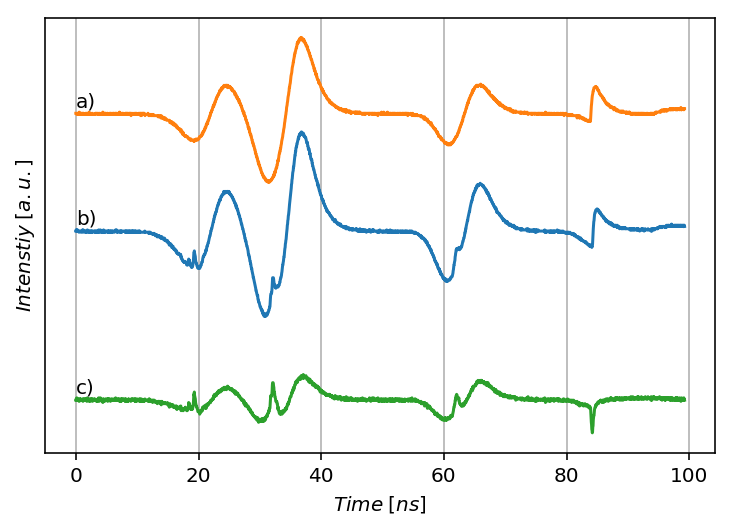

In [12]:
def getDiffCurve(name,num,xoff=0):

    data=plotGraph(name,num,visible=False)
    fig,ax=plt.subplots(dpi=144)
    data[0]+=xoff
    
    for i in range(int(len(data)/2)):
        data[i*2+1]+=10
    
    for i in range(num):
        ax.plot(data[i*2],data[i*2+1]+2*i)
    
    shuffle,j, diff_offset=[],0,7
    for i in range(len(data[2])):
        a=round(data[2][i]*100)
        b=round(data[0][j]*100)
        if a != b:
            shuffle.append(diff_offset)
            continue
        shuffle.append( data[1][j]-data[3][i]+diff_offset)
        j+=1
        
    ax.plot(data[2], shuffle)
    ax.set(yticks=[],ylabel="$Intenstiy\; [a.u.]$", xlabel="$Time\; [ns]$") #
    
    ax.text(0,12, "a)")
    ax.text(0,10,  "b)")
    ax.text(0,7.1,"c)")
    ax.grid()
    

getDiffCurve("NEW_FOL", 2,xoff=0)
# Hier wird beides dargestellt, und die Differenz vlg Fig 2 im Skript

In [11]:
# plotGraph("dafuq", 3)